## Overview
* In this project we are gonna work with Cricket T20 world cup data. This data isto be trained for prediction for the fnal result of the match. The trained model is to deployed on Streamlit application which provides a interactive application to input the data and provide prediction of the match.
* Firstly we are gonna transform the data to create our features which can be used to train the data.
* Model will trained for 5 overs performance. 
    * Last five over performance of a team will be recorded and provided to the model for it to predict the outcome
* Features we will be focusing on are:
    1. batting team name
    2. bowling team name
    3. current score - (runs scored)
    4. ball - (balls played)
    5. over - (current overs)
    6. ball_left - (balls left out of total ie. 120)
    7. wicket_left - (wickets left out of total ie. 10)
    8. crr - (current run rate)
    9. 5 ovr score - (last 5 overs run scored)
    10. final score - (total runs scored at the end of match)
    11. venue - (stadium where match is being played)

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid")

In [3]:
df = pd.read_csv('t20_wc.csv')
df.head()

,match_id,batting_team,bowling_team,ball,runs,player_dismissed,city,venue
0,2,Australia,Sri Lanka,0.1,0,0,NaN,Melbourne Cricket Ground
1,2,Australia,Sri Lanka,0.2,0,0,NaN,Melbourne Cricket Ground
2,2,Australia,Sri Lanka,0.3,1,0,NaN,Melbourne Cricket Ground
3,2,Australia,Sri Lanka,0.4,2,0,NaN,Melbourne Cricket Ground
4,2,Australia,Sri Lanka,0.5,0,0,NaN,Melbourne Cricket Ground


In [4]:
df.info(), print(), print(f'Data has {df.shape} rows and columns respectively')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63888 entries, 0 to 63887
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   match_id          63888 non-null  int64  
 1   batting_team      63888 non-null  object 
 2   bowling_team      63888 non-null  object 
 3   ball              63888 non-null  float64
 4   runs              63888 non-null  int64  
 5   player_dismissed  63888 non-null  object 
 6   city              55340 non-null  object 
 7   venue             63888 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 3.9+ MB

Data has (63888, 8) rows and columns respectively


(None, None, None)

In [5]:
df.nunique()

match_id            527
batting_team         10
bowling_team         10
ball                179
runs                  8
player_dismissed    519
city                 81
venue                94
dtype: int64

In [6]:
df.isnull().sum()

match_id               0
batting_team           0
bowling_team           0
ball                   0
runs                   0
player_dismissed       0
city                8548
venue                  0
dtype: int64

In [7]:
df[df.duplicated()]

,match_id,batting_team,bowling_team,ball,runs,player_dismissed,city,venue
38615,618,Pakistan,South Africa,0.1,1,0,Abu Dhabi,Sheikh Zayed Stadium


till now, we have checked data for any erros. 
* all the columns have correct data type
* Only city column has null values. we will check it later
* there are no repeated rows.
* **Conclusion:** data seems to be clean

In [9]:
df.drop(38615, inplace=True)

In [10]:
df[df['city'].isnull()]['venue'].value_counts()

venue
Dubai International Cricket Stadium        2969
Pallekele International Cricket Stadium    2066
Melbourne Cricket Ground                   1453
Sydney Cricket Ground                       749
Adelaide Oval                               498
Harare Sports Club                          372
Sharjah Cricket Stadium                     249
Sylhet International Cricket Stadium        128
Carrara Oval                                 64
Name: count, dtype: int64

* we can identify the missing city names has venue names. And mostly stadium is named after city.
* Thus, we can verify all city names with null values have venue names starting with the name of a city.
* We can extract the first word and add them in city column

In [12]:
df['city'] = df['city'].mask(df['city'].isnull(), df['venue'].str.split().str.get(0))

In [13]:
df.isnull().sum()

match_id            0
batting_team        0
bowling_team        0
ball                0
runs                0
player_dismissed    0
city                0
venue               0
dtype: int64

* now, no column has null values

* for our model to work best, we require atleast 5 matches in a city to have accurate data.
* single inning contains 120 balls. 5 inning contains 600 balls

In [15]:
city_count = df['city'].value_counts()
eli_city = city_count[city_count > 599].index.tolist()

df_model = df[df['city'].isin(eli_city)]

* Now lets work on transforming the data and creating our features

1. Below we have calculated the total score after each ball
2. Number of ongoing over
3. number of balls delivered
4. total balls delivered
5. total number of boundries hit (4s & 6s)
6. number of balls left 
7. number of players dismissed
8. total wickets left
9. Current run rate
10. last 5 over socre

In [17]:
df_model['score'] = df_model.groupby('match_id')['runs'].cumsum()
df_model['over'] = df_model['ball'].astype(int)
df_model['ball'] = df_model['ball'].astype(str).str.extract(r"\d.(\d)").astype(int)
df_model['total balls'] = (df_model['over']*6) + df_model['ball']

In [18]:
df_model['extras'] = 0
df_model["4s"] = 0
df_model["6s"] = 0

for i in df_model['match_id'].unique():
    #extras
    mask_extras = (df_model['match_id'] == i) & (df_model['ball'] > 6)
    df_model.loc[mask_extras, 'extras'] = df_model.loc[mask_extras, 'ball'].gt(6).cumsum()
    
    #4's
    mask_4s = (df_model['match_id'] == i) & (df_model['runs'] == 4)
    df_model.loc[mask_4s, '4s'] = 1
    
    #6's
    mask_6s = (df_model['match_id'] == i) & (df_model['runs'] == 6)
    df_model.loc[mask_6s, '6s'] = 1

In [19]:
df_model['ball_left'] = 120 - df_model['total balls']
df_model['ball_left'].mask(df_model['ball_left']<0,0, inplace=True)

df_model['player_dismissed'] = df_model['player_dismissed'].mask(df_model['player_dismissed'] != '0', 1).astype(int)
df_model['player_dismissed'] = df_model.groupby('match_id')['player_dismissed'].cumsum()

df_model['wicket_left'] = 10 - df_model['player_dismissed']

In [20]:
df_model['crr'] = round(df_model.apply(lambda row: 0 if row['over'] == 0 else row['score'] / row['over'], axis=1),2)

df_model['5 ovr score'] = df_model.groupby('match_id')['runs'].rolling(window=30).sum().values.tolist()
df_model['5 ovr score'].fillna(0,inplace=True)

In [21]:
df_model.head()

,match_id,batting_team,bowling_team,ball,runs,player_dismissed,city,venue,score,over,total balls,extras,4s,6s,ball_left,wicket_left,crr,5 ovr score
0,2,Australia,Sri Lanka,1,0,0,Melbourne,Melbourne Cricket Ground,0,0,1,0,0,0,119,10,0.0,0.0
1,2,Australia,Sri Lanka,2,0,0,Melbourne,Melbourne Cricket Ground,0,0,2,0,0,0,118,10,0.0,0.0
2,2,Australia,Sri Lanka,3,1,0,Melbourne,Melbourne Cricket Ground,1,0,3,0,0,0,117,10,0.0,0.0
3,2,Australia,Sri Lanka,4,2,0,Melbourne,Melbourne Cricket Ground,3,0,4,0,0,0,116,10,0.0,0.0
4,2,Australia,Sri Lanka,5,0,0,Melbourne,Melbourne Cricket Ground,3,0,5,0,0,0,115,10,0.0,0.0


* Now we need to know the total runs scored at the end of match. And add it to the original Data Frame

In [42]:
group_team_name = df_model.groupby('batting_team')[['runs', 'player_dismissed', 'extras', 'ball', '4s', '6s']].sum().reset_index()
group_team_name = group_team_name.sort_values(by=['batting_team'], ascending=False)

runs_sum = df_model.groupby('batting_team')['runs'].sum().reset_index()
runs_max = df_model.groupby('batting_team')['score'].max().sort_values(ascending=False)

# team_4s = df_model.groupby('batting_team')['4s'].sum().sort_values(ascending=False)
# team_6s = df_model.groupby('batting_team')['6s'].sum().sort_values(ascending=False)

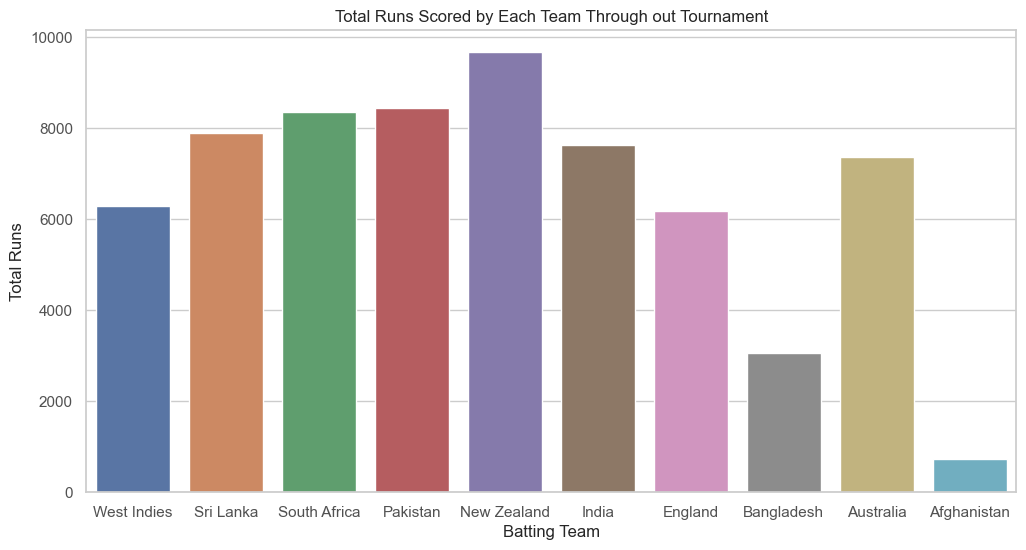

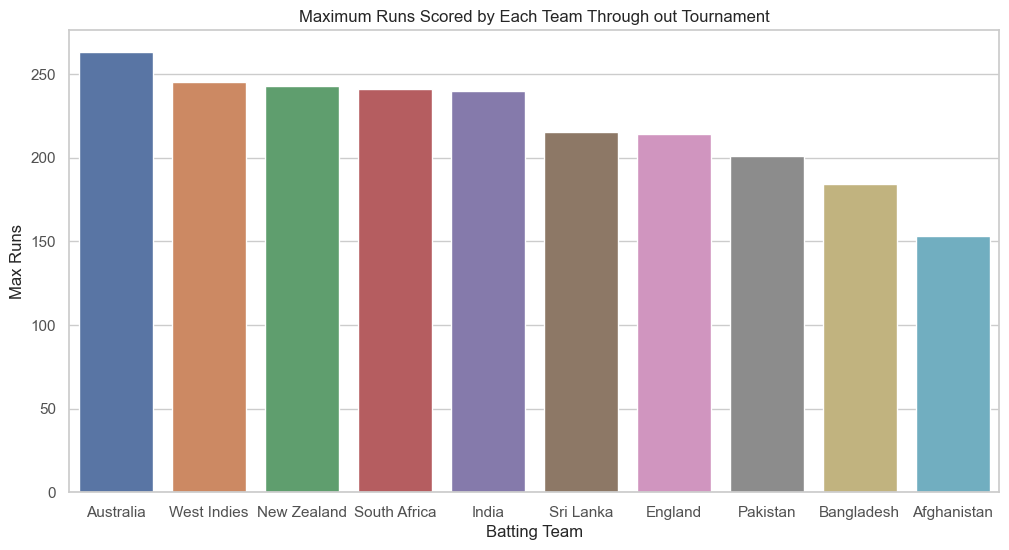

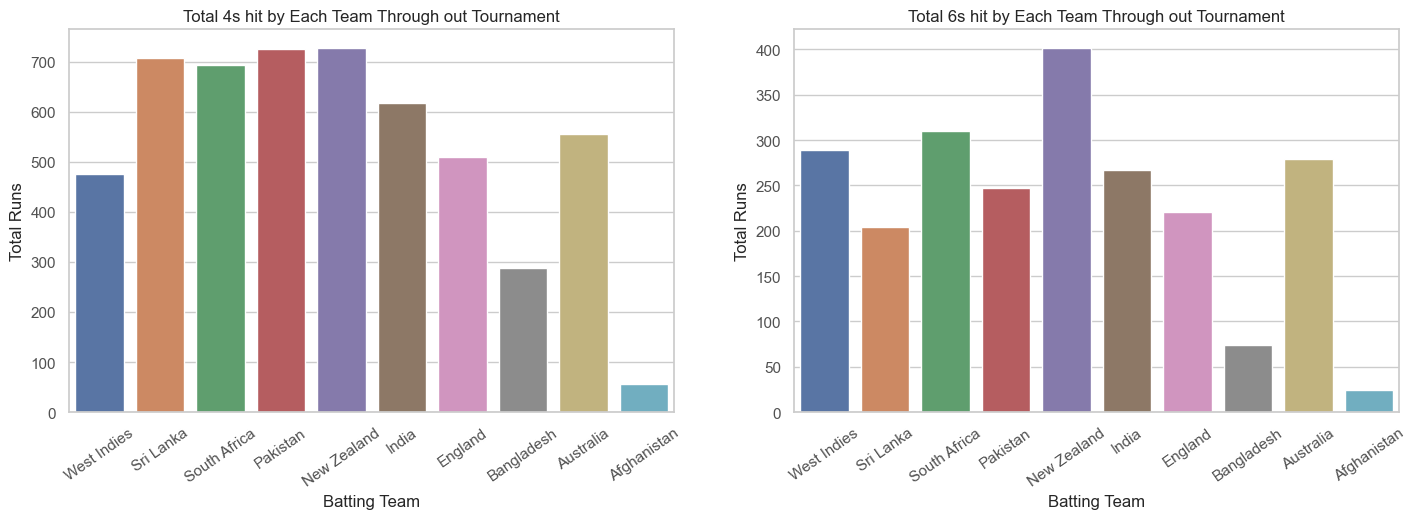

In [46]:
# Total Runs
plt.figure(figsize=(12, 6))
sns.barplot(x='batting_team', y='runs', data=group_team_name)
plt.xlabel('Batting Team')
plt.ylabel('Total Runs')
plt.title('Total Runs Scored by Each Team Through out Tournament')
plt.xticks(alpha=0.8)
plt.yticks(alpha=0.8)
# plt.savefig('Total Runs Scored by Each Team Through out Tournament')

# Max runs
plt.figure(figsize=(12, 6))
sns.barplot(x=runs_max.index, y=runs_max.values)
plt.xlabel('Batting Team')
plt.ylabel('Max Runs')
plt.title('Maximum Runs Scored by Each Team Through out Tournament')
plt.xticks(alpha=0.8)
plt.yticks(alpha=0.8)
# plt.savefig('Maximum Runs Scored by Each Team Through out Tournament')

# Total4s
plt.figure(figsize=(15, 6))
plt.subplot(121)
sns.barplot(x='batting_team', y='4s', data=group_team_name)
plt.xlabel('Batting Team')
plt.ylabel('Total Runs')
plt.title('Total 4s hit by Each Team Through out Tournament')
plt.xticks(rotation = 35, alpha=0.8)
plt.yticks(alpha=0.8)
# plt.savefig('Total 4s hit by Each Team Through out Tournament')

# Total 6s
plt.subplot(122)
sns.barplot(x='batting_team', y='6s', data=group_team_name)
plt.xlabel('Batting Team')
plt.ylabel('Total Runs')
plt.title('Total 6s hit by Each Team Through out Tournament')
plt.xticks(rotation = 35, alpha=0.8)
plt.yticks(alpha=0.8)
# plt.savefig('Total 6s hit by Each Team Through out Tournament')

plt.tight_layout(pad=3)
plt.show()

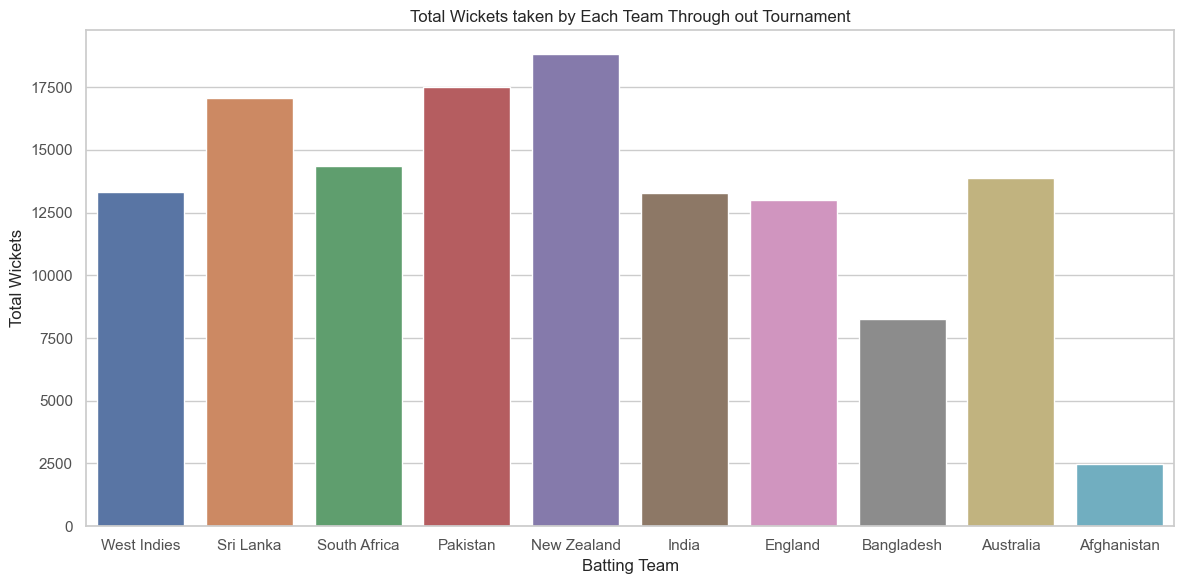

In [25]:
plt.figure(figsize=(12, 6))

sns.barplot(x='batting_team', y='player_dismissed', data=group_team_name)
plt.xlabel('Batting Team')
plt.ylabel('Total Wickets')
plt.title('Total Wickets taken by Each Team Through out Tournament')
plt.xticks(alpha=0.8)
plt.yticks(alpha=0.8)
# plt.savefig('Total Wickets taken by Each Team Through out Tournament')

plt.tight_layout()
plt.show()

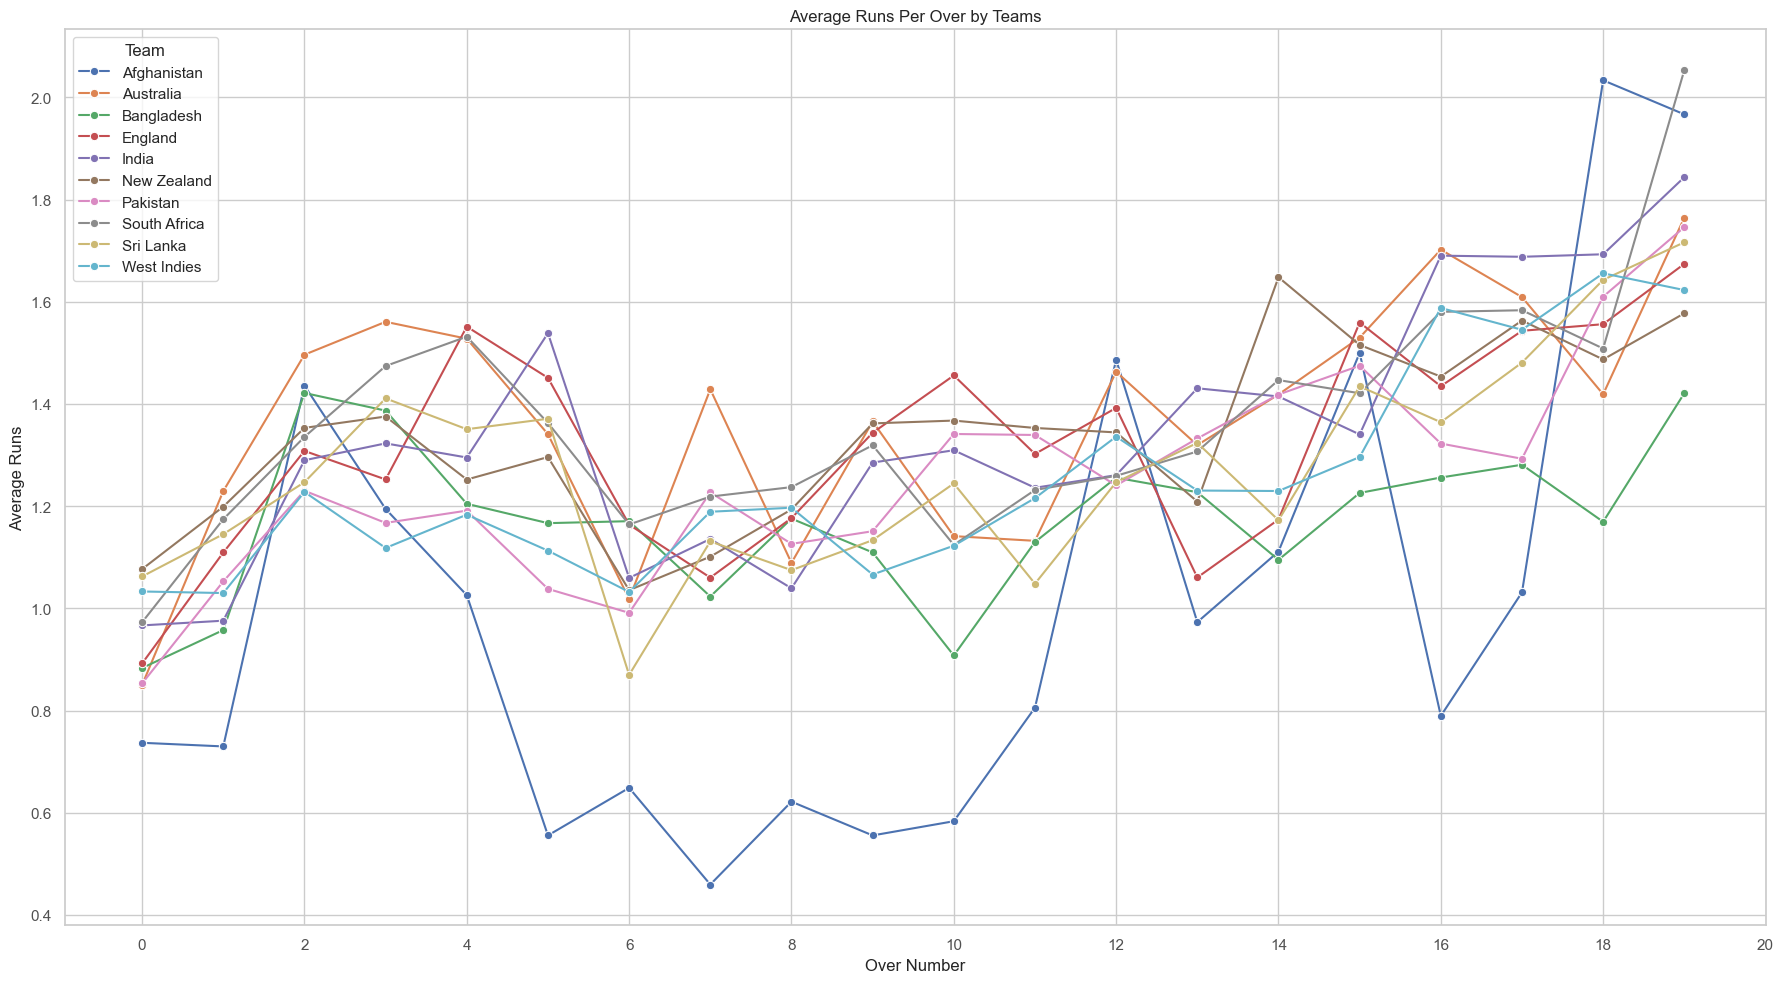

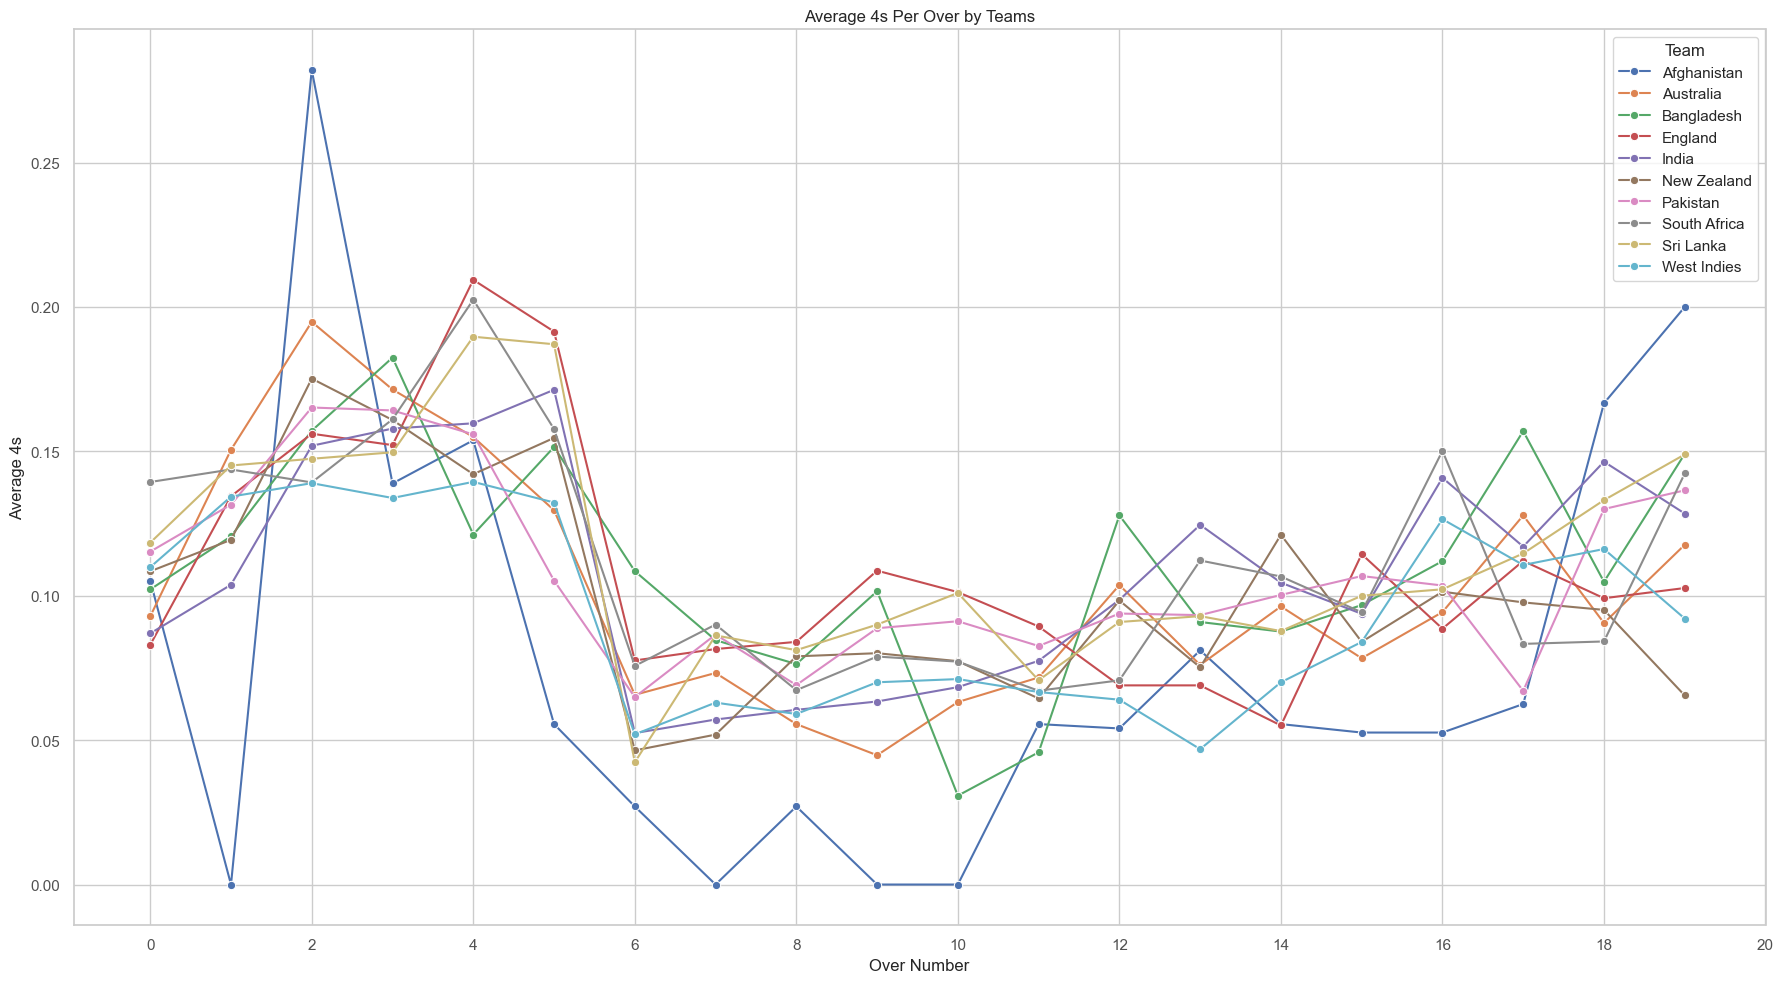

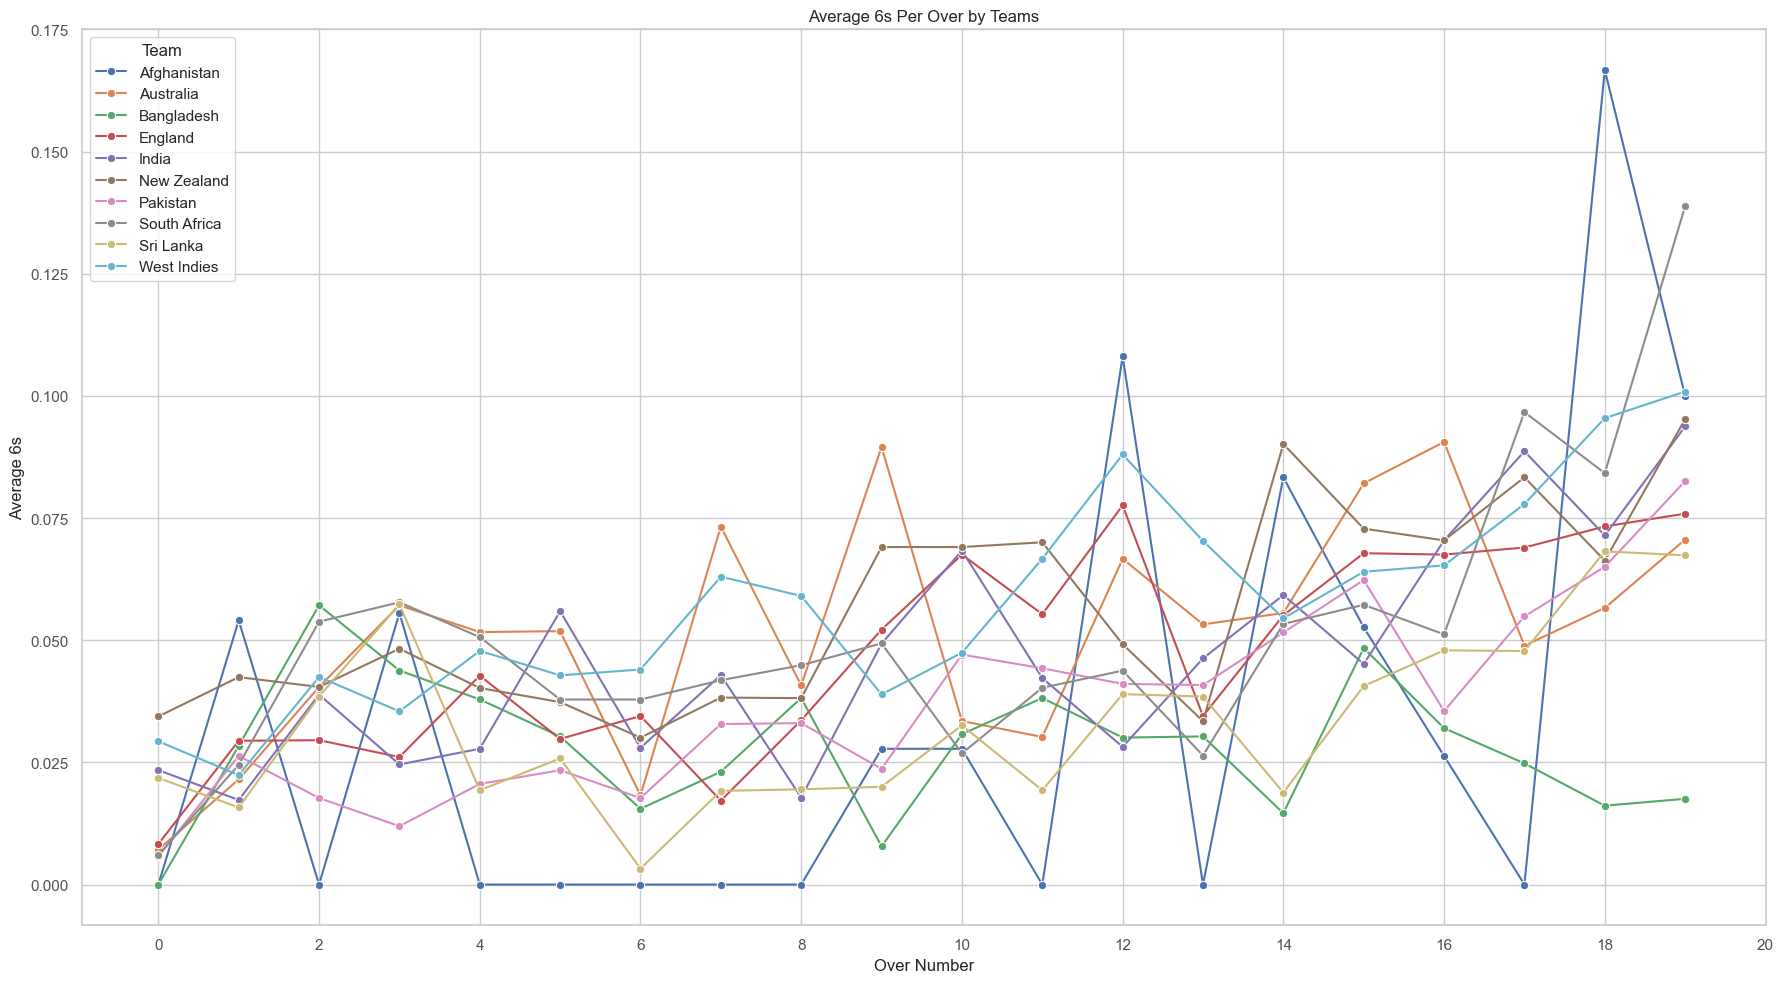

In [56]:
average_runs_per_over = df_model.groupby(['batting_team', 'over'])['runs'].mean().reset_index()
average_4s_per_over = df_model.groupby(['batting_team', 'over'])['4s'].mean().reset_index()
average_6s_per_over = df_model.groupby(['batting_team', 'over'])['6s'].mean().reset_index()

plt.figure(figsize=(18, 10))
for team in average_runs_per_over['batting_team'].unique():
    team_data = average_runs_per_over[average_runs_per_over['batting_team'] == team]
    sns.lineplot(data=team_data, x='over', y='runs', label=team, marker='o')
plt.xticks(ticks=range(0, 21, 2), alpha=0.8)
plt.yticks(alpha=0.8)
plt.title('Average Runs Per Over by Teams')
plt.xlabel('Over Number')
plt.ylabel('Average Runs')
plt.legend(title='Team')
plt.grid(True)
plt.tight_layout()
# plt.savefig('Average Runs Per Over by Teams')
plt.show()

# Average 4s Per Over
plt.figure(figsize=(18, 10))
for team in average_4s_per_over['batting_team'].unique():
    team_data = average_4s_per_over[average_4s_per_over['batting_team'] == team]
    sns.lineplot(data=team_data, x='over', y='4s', label=team, marker='o')
plt.xticks(ticks=range(0, 21, 2), alpha=0.8)
plt.yticks(alpha=0.8)
plt.title('Average 4s Per Over by Teams')
plt.xlabel('Over Number')
plt.ylabel('Average 4s')
plt.legend(title='Team')
plt.grid(True)
plt.tight_layout()
# plt.savefig('Average 4s Per Over by Teams')
plt.show()

# Average 6s Per Over
plt.figure(figsize=(18, 10))
for team in average_6s_per_over['batting_team'].unique():
    team_data = average_6s_per_over[average_6s_per_over['batting_team'] == team]
    sns.lineplot(data=team_data, x='over', y='6s', label=team, marker='o')
plt.xticks(ticks=range(0, 21, 2), alpha=0.8)
plt.yticks(alpha=0.8)
plt.title('Average 6s Per Over by Teams')
plt.xlabel('Over Number')
plt.ylabel('Average 6s')
plt.legend(title='Team')
plt.grid(True)
plt.tight_layout()
# plt.savefig('Average 6s Per Over by Teams')
plt.show()

In [27]:
venue_scoreGroup = df_model.groupby('venue')['score'].max().sort_values(ascending=False)
venue_mean = df_model.groupby('venue')['score'].mean().sort_values(ascending=False)

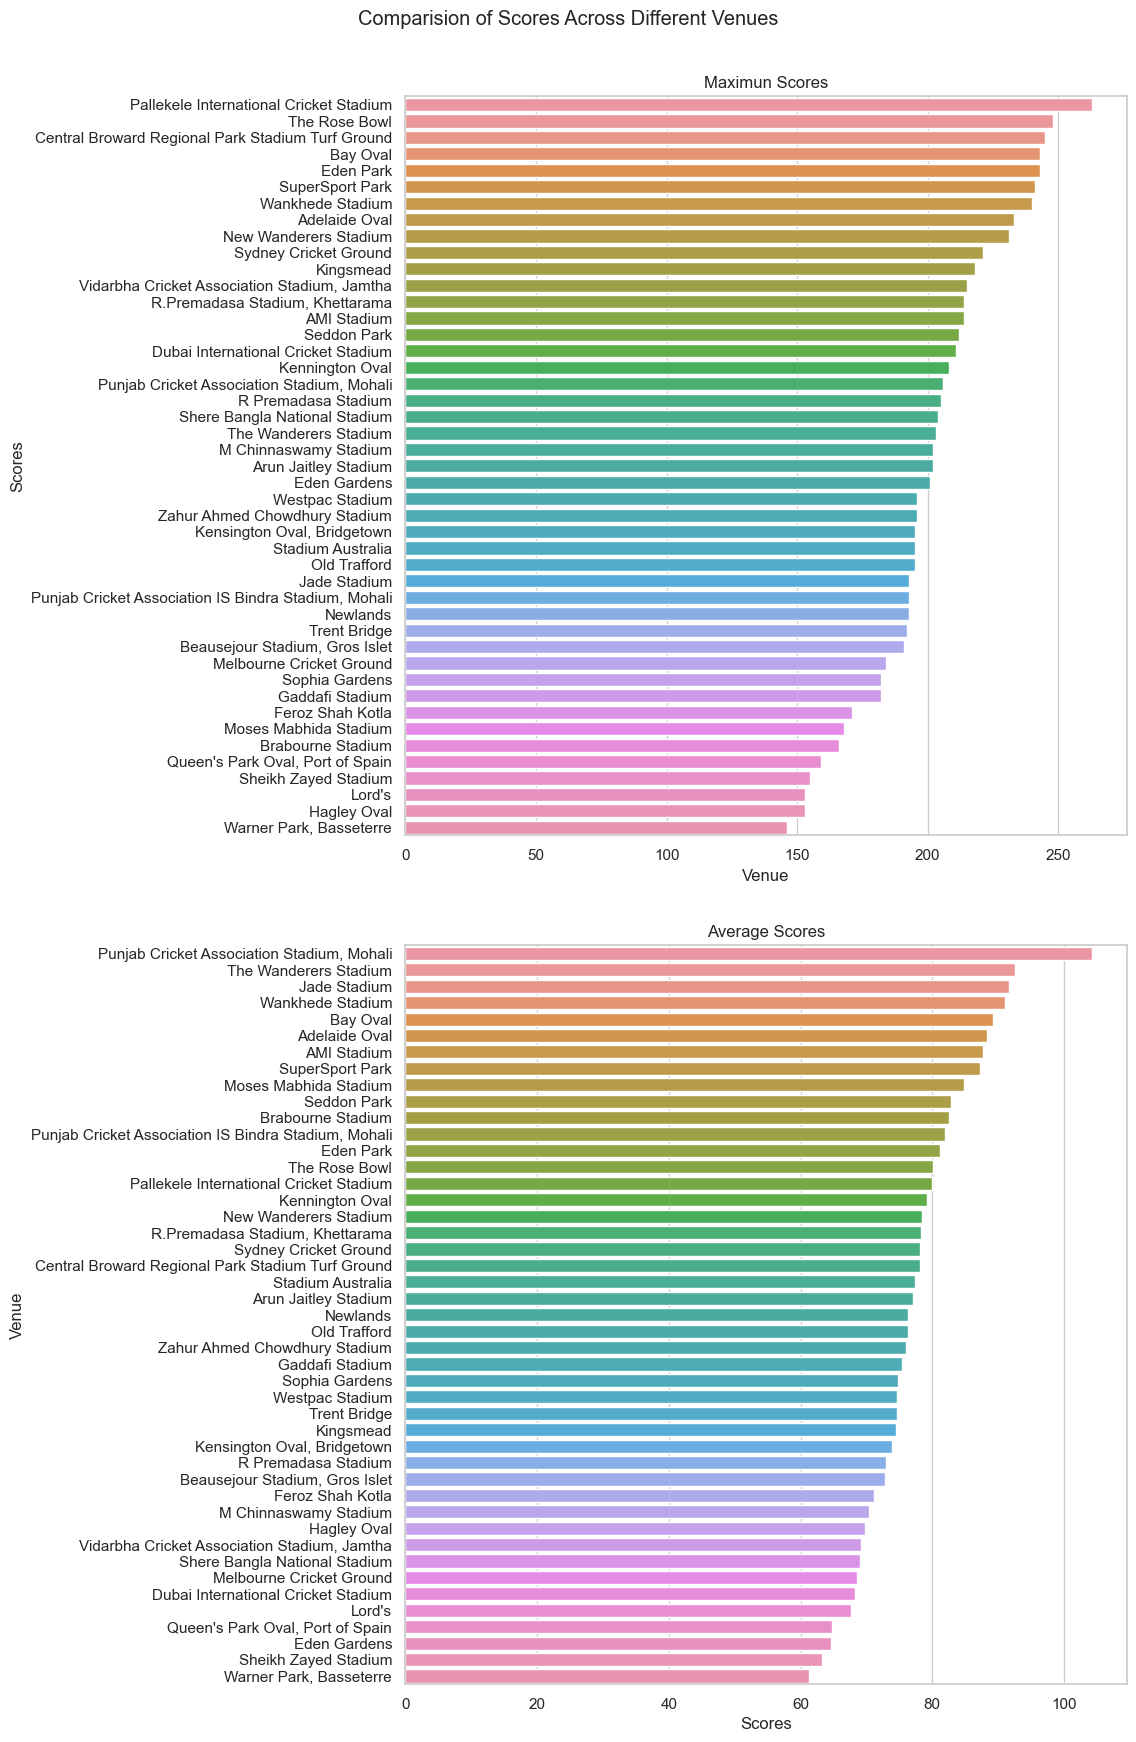

In [28]:
plt.figure(figsize=(12, 18))
plt.suptitle('Comparision of Scores Across Different Venues')

plt.subplot(211)
sns.barplot(y=venue_scoreGroup.index, x=venue_scoreGroup.values)
plt.title('Maximun Scores')
plt.xlabel('Venue')
plt.ylabel('Scores')
# plt.savefig('Maximun Scores')

# Create a horizontal bar plot
plt.subplot(212)
sns.barplot(x=venue_mean.values, y=venue_mean.index)
plt.title('Average Scores')
plt.xlabel('Scores')
plt.ylabel('Venue')
# plt.savefig('Average Scores')

plt.tight_layout(pad=2.5)
plt.show()

In [29]:
wicket_max = df_model.groupby('venue')['player_dismissed'].sum().sort_values(ascending=False)
wicket_mean = df_model.groupby('venue')['player_dismissed'].mean().sort_values(ascending=False)

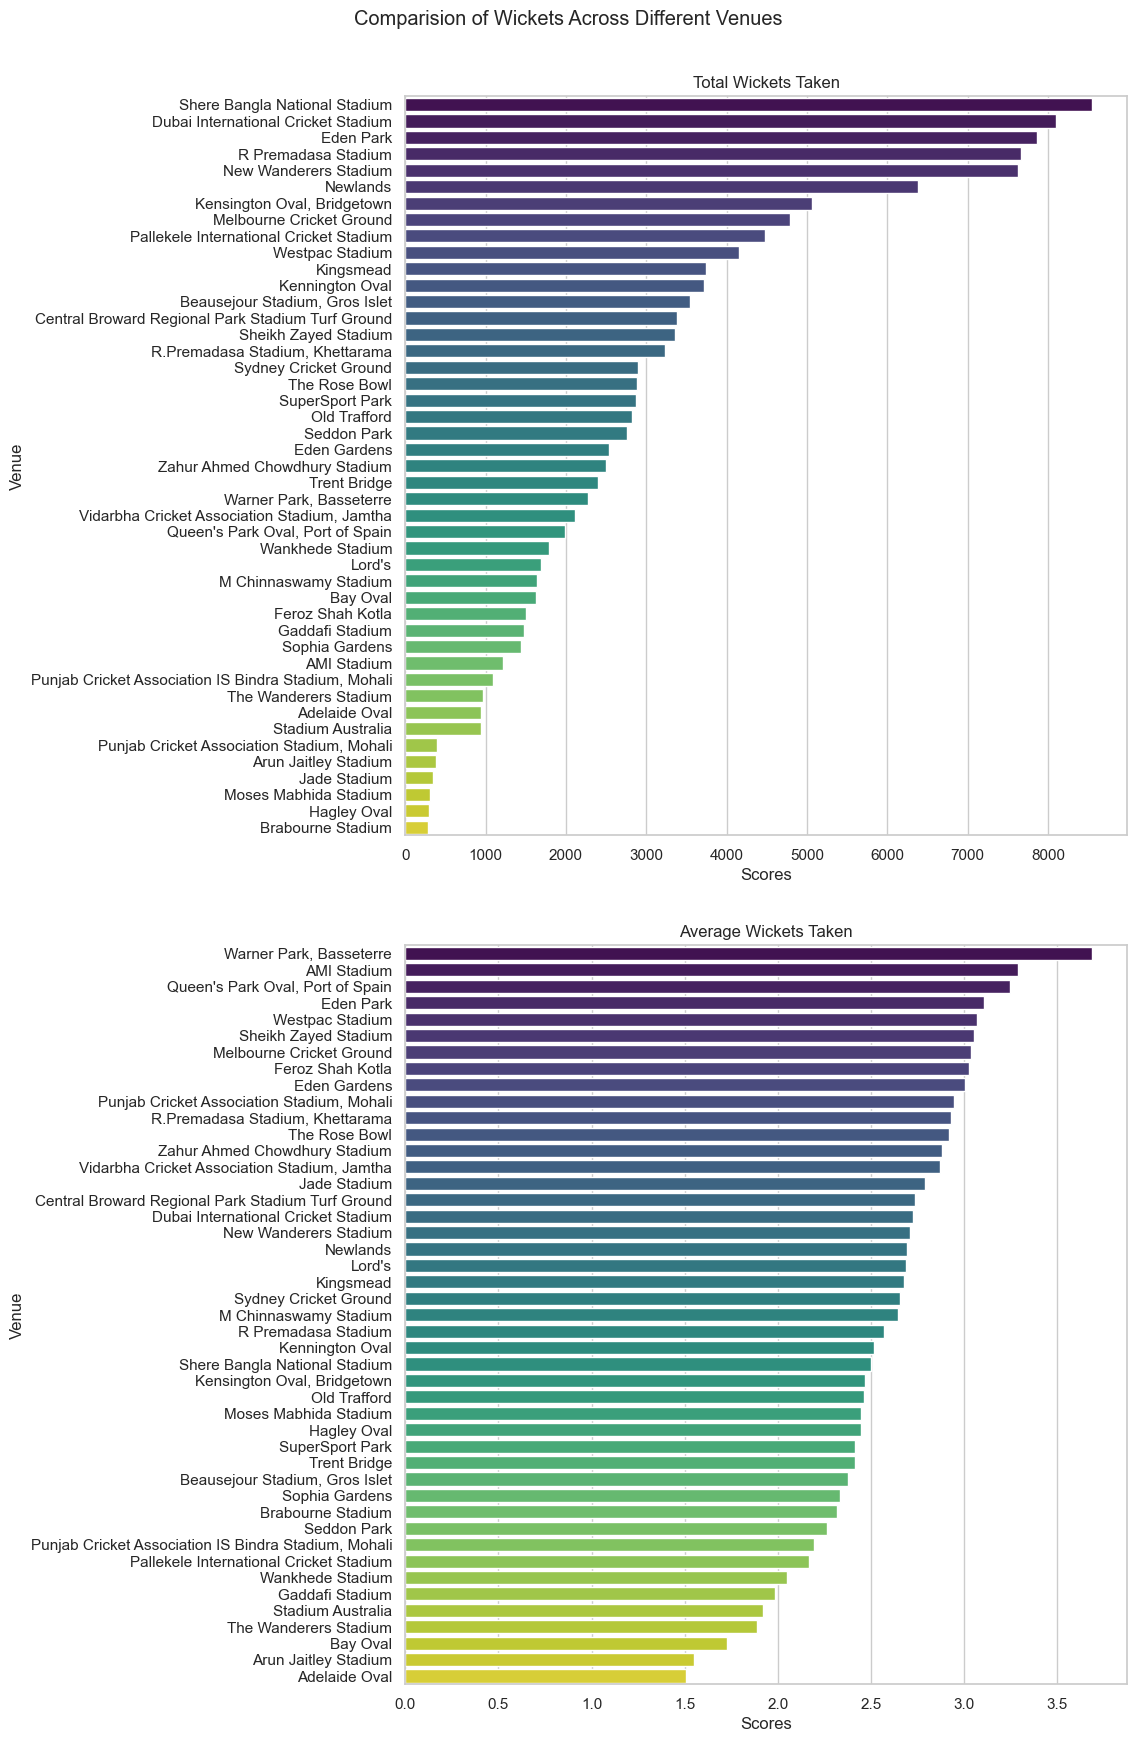

In [30]:
plt.figure(figsize=(12, 18))
plt.suptitle('Comparision of Wickets Across Different Venues')

plt.subplot(211)
sns.barplot(y=wicket_max.index, x=wicket_max.values, palette='viridis')
plt.title('Total Wickets Taken')
plt.ylabel('Venue')
plt.xlabel('Scores')
# plt.savefig('Total Wickets Taken')

# Create a horizontal bar plot
plt.subplot(212)
sns.barplot(x=wicket_mean.values, y=wicket_mean.index, palette='viridis')
plt.title('Average Wickets Taken')
plt.xlabel('Scores')
plt.ylabel('Venue')
# plt.savefig('Average Wickets Taken')

plt.tight_layout(pad=2.5)
plt.show()

## Individual Team Analysis

In [32]:
def visualize_team_stats(team_name):
    # Filter data for the specified team
    batt = df_model[df_model['batting_team'] == team_name]
    bowl = df_model[df_model['bowling_team'] == team_name]

    # Group by operations for batting data
    runs_group = batt.groupby('bowling_team')[['extras', '4s', '6s']].sum()
    wicket_group = batt.groupby('bowling_team')['player_dismissed'].sum().sort_values(ascending=False)

    # Plotting runs_group
    fig, ax1 = plt.subplots(figsize=(12, 6))
    runs_group.plot(kind='bar', stacked=True, ax=ax1, color=['#FF9999', '#66B3FF', '#99FF99'])
    plt.title(f"Run Chase Given To Each Team by {team_name}")
    plt.xlabel('Team')
    plt.ylabel('Score')
    # plt.savefig(f"Run Chase Given To Each Team by {team_name}")
    plt.show()

    # Plotting wicket_group
    fig, ax2 = plt.subplots(figsize=(12, 6))
    sns.barplot(x=wicket_group.index, y=wicket_group.values, ax=ax2)
    plt.title(f"Wickets Lost to Each Team by {team_name}")
    plt.xlabel('Team')
    plt.ylabel('Total Wickets')
    # plt.savefig(f"Wickets Lost to Each Team by {team_name}")
    plt.show()

    # Group by operations for bowling data
    bowl_runs_group = bowl.groupby('batting_team')[['extras', '4s', '6s']].sum()
    bowl_wicket_group = bowl.groupby('batting_team')['player_dismissed'].sum().sort_values(ascending=False)

    # Plotting bowl_runs_group
    fig, ax1 = plt.subplots(figsize=(12, 6))
    bowl_runs_group.plot(kind='bar', stacked=True, ax=ax1, color=['#FF9999', '#66B3FF', '#99FF99'])
    plt.title(f"Run Chase Given by {team_name}")
    plt.xlabel('Team')
    plt.ylabel('Score')
    # plt.savefig(f"Run Chase Given by {team_name}")
    plt.show()

    # Plotting bowl_wicket_group
    fig, ax2 = plt.subplots(figsize=(12, 6))
    sns.barplot(x=bowl_wicket_group.index, y=bowl_wicket_group.values, ax=ax2)
    plt.title(f"Wickets Taken by {team_name}")
    plt.xlabel('Team')
    plt.ylabel('Total Wickets')
    # plt.savefig(f"Wickets Taken by {team_name}")
    plt.show()

    # Group by operations for venue data
    team_venue = pak_bowl.groupby('venue')[['runs', 'extras', '4s', '6s']].sum().reset_index()

    # Plotting scores across different venues
    plt.figure(figsize=(12, 12))
    sns.barplot(x=team_venue['runs'], y=team_venue['venue'])
    plt.title(f"Scores Across Different Venues by {team_name}")
    plt.xlabel('Scores')
    plt.ylabel('Venue')
    # plt.savefig(f"Scores Across Different Venues by {team_name}")
    plt.show()

    # Calculate and plot average runs per over for batting
    batt_avg_runs_per_over = batt.groupby('over')['runs'].mean()
    plt.figure(figsize=(12, 8))
    plt.subplot(211)
    plt.plot(batt_avg_runs_per_over.index, batt_avg_runs_per_over.values, marker='o')
    plt.title(f'Average Runs Scored per Over by {team_name}')
    plt.xlabel('Over')
    plt.ylabel('Average Runs')
    # plt.savefig(f'Average Runs Scored per Over by {team_name}')
    plt.grid(True)

    # Calculate and plot average runs per over for bowling
    bowl_avg_runs_per_over = bowl.groupby('over')['runs'].mean()
    plt.subplot(212)
    plt.plot(bowl_avg_runs_per_over.index, bowl_avg_runs_per_over.values, marker='o')
    plt.title(f'Average Runs Received per Over by {team_name}')
    plt.xlabel('Over')
    plt.ylabel('Average Runs')
    # plt.savefig(f'Average Runs Received per Over by {team_name}')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Example usage:
# visualize_team_stats('Pakistan', df_model)


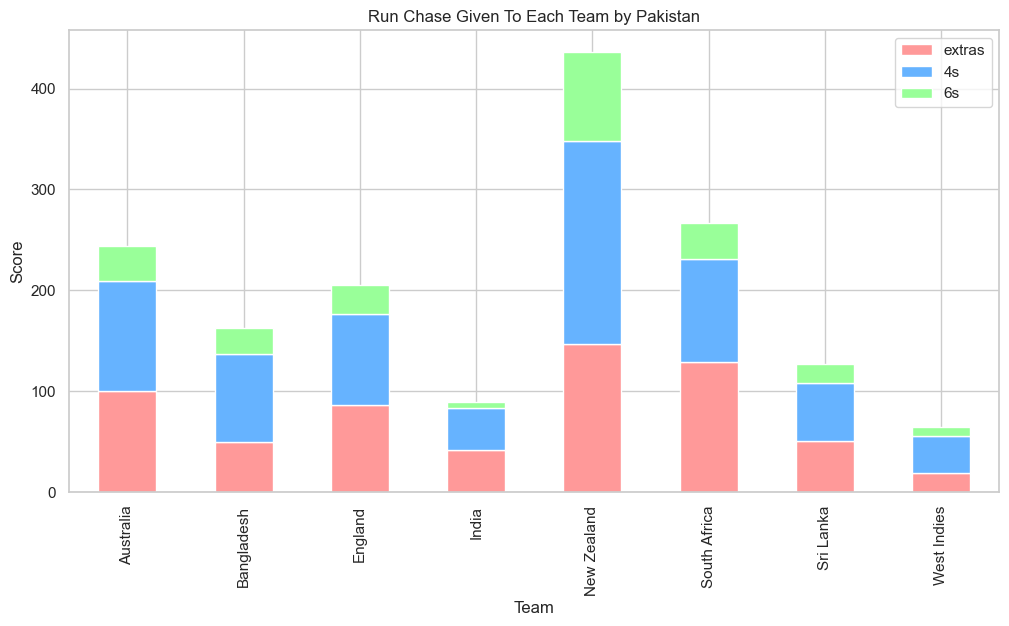

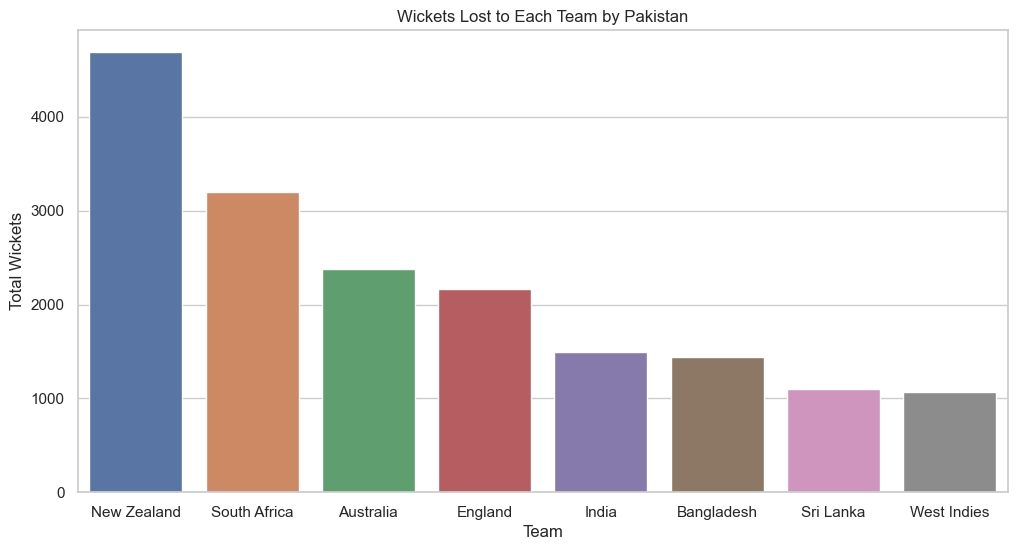

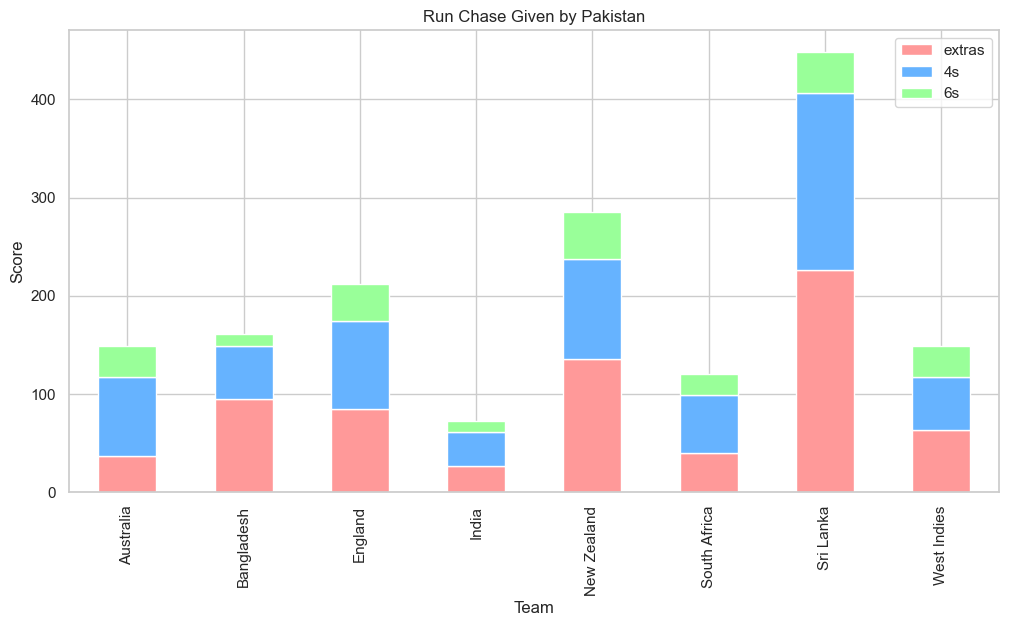

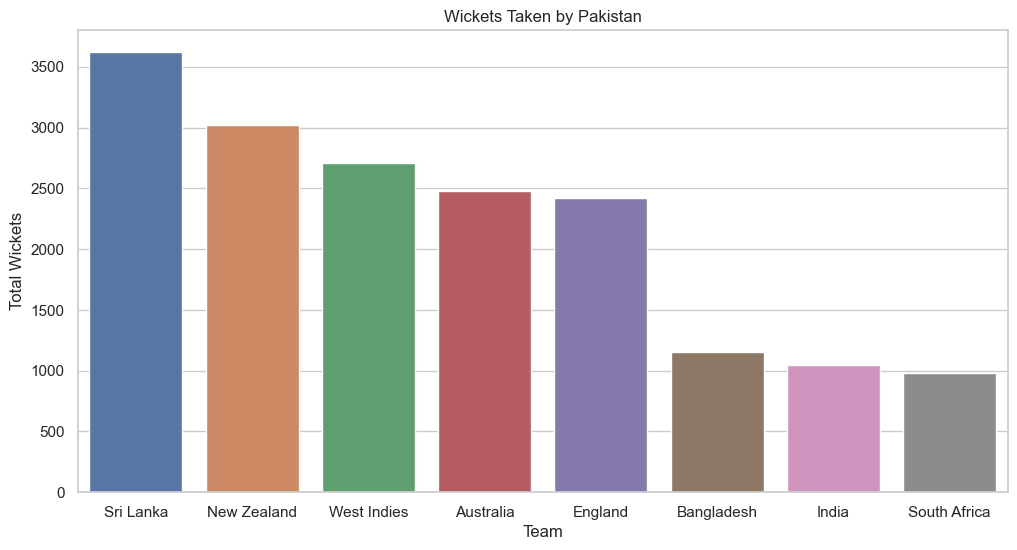

NameError: name 'pak_bowl' is not defined

In [33]:
visualize_team_stats('Pakistan')

## Prediction

In [ ]:
total_score = df_model.groupby('match_id')['runs'].sum().reset_index()

In [ ]:
df_model = df_model.merge(total_score, on='match_id')

* Now filter the columns and select features

In [ ]:
# df_model.columns

In [ ]:
order = ['batting_team', 'bowling_team', 'runs_x', 'over', 'ball_left', 'wicket_left', 'crr', '5 ovr score', 'city',
         'runs_y']

final_df = df_model[order].copy()

In [ ]:
final_df.rename(columns={'runs_x': 'current score', 'runs_y': 'final score', '5 ovr score':'5ovr_score'}, inplace=True)

In [ ]:
final_df.isnull().sum()

* As we caluculated `5 ovr score`, the first 4 over over data of this column will be null.
* our model requires data with minimum 5 overs
* The null rows will be droppped as keeping it will harm the model's accuracy.

In [ ]:
final_df.dropna(inplace=True)
final_df.isnull().sum()

* We need complete data for the model.
* Thus, we will create a sample of complete data which will jumble up the rows to reduce the biasness.

In [ ]:
model = final_df.sample(final_df.shape[0])

In [ ]:
# model.columns

* We have successfully transformed the data and finalised our features.
* Next step is work training the model and creating the streamlit app
* below we have stored all features in `X` and output column in `y`

In [ ]:
X = final_df.drop(columns = ['final score'])
y = final_df['final score']

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=1)

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score,mean_absolute_error

* `OneHotEncoder` helps encoding categorical data into binary format.
* As 

In [ ]:
trf = ColumnTransformer([
    ('trf',OneHotEncoder(sparse=False),['batting_team','bowling_team', 'city'])
]
,remainder='passthrough')

* Below we have created a pipline and defined 3 steps.
    1. OneHotEncode the categorical columns.
    2. StandardScaler is used to bring all the data under one scale range.
    3. XGRegressor helps in dealing with model containging many features and they provide a numberical outcome.

In [ ]:
pipe = Pipeline(steps=[
            ('step1', trf),
            ('step2', StandardScaler()),
            ('step3', XGBRegressor(n_estimators=520, learning_rate=0.1, max_depth=12, random_state=1))
])

In [ ]:
pipe.fit(X_train,y_train)
y_pred = pipe.predict(X_test)
print(r2_score(y_test,y_pred))
print(mean_absolute_error(y_test,y_pred))

* model trained and saved in  pickle file format 

In [ ]:
pickle.dump(pipe, open("t20_model.pkl","wb"))

In [ ]:
# df_model['city'].unique()

In [ ]:
model.info()

* below we created a interactive GUI for our model using `ipywidgets library`.
* we can input the parameters asked and it will display the predicted outcome.

In [ ]:
from ipywidgets import widgets, Layout
from IPython.display import display
import joblib

# your pickle file
model = joblib.load('t20_model.pkl')


teams = ['Australia', 'New Zealand', 'South Africa', 'England', 'India', 'West Indies', 'Pakistan', 'Bangladesh', 
         'Afghanistan', 'Sri Lanka']

cities = ['Melbourne', 'Adelaide', 'Mount Maunganui', 'Auckland', 'Southampton', 'Cardiff', 'Nagpur', 'Bangalore', 
          'Lauderhill', 'Dubai', 'Abu Dhabi', 'Sydney', 'Wellington', 'Hamilton', 'Barbados', 'Trinidad', 'Colombo', 
          'St Kitts', 'Manchester', 'Delhi', 'Lahore', 'Johannesburg', 'Centurion', 'Cape Town', 'Mumbai', 'Kolkata', 
          'Durban', 'Chandigarh', 'Christchurch', 'London', 'Nottingham', 'St Lucia', 'Pallekele', 'Mirpur', 'Chittagong']

# input widgets and placeholders
batting_team = widgets.Dropdown(options=teams, description='Batting Team:', layout=Layout(width='200px'), 
                                placeholder='Select Batting Team')

bowling_team = widgets.Dropdown(options=teams, description='Bowling Team:', layout=Layout(width='200px'), 
                                placeholder='Select Bowling Team')

current_score = widgets.FloatText(description='Current Score:', layout=Layout(width='200px'), 
                                  placeholder='Enter Current Score')

overs = widgets.FloatText(description='No. of Overs Done (>5):', layout=Layout(width='200px'), 
                          placeholder='Enter Overs')

wickets = widgets.FloatText(description='Wickets Out:', layout=Layout(width='200px'), placeholder='Enter Wickets Out')
last_five_overs = widgets.FloatText(description='Runs Scored in Last Five Overs:', 
                                    layout=Layout(width='200px'), placeholder='Enter Runs Scored')


city = widgets.Dropdown(options=cities, description='City:', layout=Layout(width='200px'), placeholder='Select City')

# function to predict final score
def predict_score(batting_team, bowling_team, current_score, overs, wickets, last_five_overs, city):
    balls_left = 120 - (overs * 6)
    wickets_left = 10 - wickets

    
    if overs > 5:
        crr = current_score / overs
    else:
        crr = 0

    input_data = {
        'batting_team': [batting_team],
        'bowling_team': [bowling_team],
        'current score': [current_score],
        'over': [overs],
        'ball_left': [balls_left],
        'wicket_left': [wickets_left],
        'crr': [crr],
        '5ovr_score': [last_five_overs],
        'city': [city]  
    }

    # prediction
    predicted_score = model.predict(pd.DataFrame(input_data))
    result_label.value = "Predicted Score: " + str(int(predicted_score[0]))

# button for prediction
predict_button = widgets.Button(description='Predict Score')
predict_button.on_click(lambda b: predict_score(batting_team.value, bowling_team.value, current_score.value, overs.value, 
                                                wickets.value, last_five_overs.value, city.value))


result_label = widgets.Label(value='Predicted Score:')

# widgets Display
display(batting_team)
display(bowling_team)
display(current_score)
display(overs)
display(wickets)
display(last_five_overs)
display(city) 
display(predict_button)
display(result_label)